# the goal of this code is to:
# video -> .csv -> loading bar

In [13]:
import pandas as pd
import numpy as np
import sys
import cv2

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rcParams
from matplotlib.ticker import MaxNLocator
rcParams.update({'figure.autolayout': True, 'ytick.left': False, 'ytick.labelleft': False, 'font.size':24, 'xtick.bottom': False, 'xtick.labelbottom': False})

from IPython.display import HTML

In [4]:
def draw_barchart(row):
    print("Exporting graphic frame", row, end="\r")
    row, rem = divmod(row, SECS_PER_INTERVAL*FPS)
    rem /= FPS
    ax.clear()
    ax.xaxis.set_major_locator(MaxNLocator(prune='upper')) #removes label at right, which sometimes scrunches graph
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1)

    data = df.iloc[:(row+1), :]
    for i in range(0, row+1):
        if i == row: #last one!
            ax.barh(0, rem, left=data.at[i, "start_seconds"], \
                    color = color_dict[data.at[i, "predicted_label"]])
            ax.set_xlim([0, data.at[i, "start_seconds"]+rem])
            
        else:
            ax.barh(0, data.at[i, "duration"], left=data.at[i, "start_seconds"], \
                    color = color_dict[data.at[i, "predicted_label"]])

    ax.margins(0.15)

<ipython-input-4-ffdfcbd5cbbf>:14: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim([0, data.at[i, "start_seconds"]+rem])


Created sphincterotomy10_action_graphic!


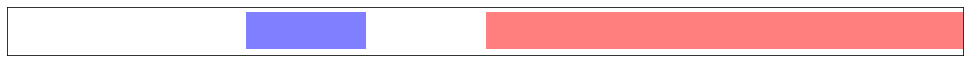

In [9]:
###############################################################
directory = "/pasteur/u/egoodma/clinical_analysis/videos/SPHINCTEROTOMY/"
video_name = "sphincterotomy10"
###############################################################
SECS_PER_INTERVAL = 5 #could set this to 1 if you just want 5 frame resolution
FPS = 30
color_dict = {"background":(1, 1, 1, 1), "cutting":(1,0,0,0.5), "suturing":(0,1,0,0.5), "tying":(0,0,1,0.5)}

#move to folder and choose surgery action .csv
df = pd.read_csv(directory+video_name+".csv")

#core code to make video
fig, ax = plt.subplots(figsize=(14, 1.4))
fig.subplots_adjust(left=0,right=1,bottom=0,top=1)

animator = animation.FuncAnimation(fig, draw_barchart, frames=range(0, FPS*SECS_PER_INTERVAL*df.shape[0]))

#use this option to view the movie in the jupyter notebook
#HTML(animator.to_jshtml()) 

#use this option to save movie in current directory
Writer = animation.writers['ffmpeg']
writer = Writer(fps=FPS, metadata=dict(artist='Me'), bitrate=1800)
animator.save(directory+video_name+"_action_graphic.mp4", writer = writer)
print("Created {}_action_graphic!".format(video_name))

In [12]:
surgery_vid = cv2.VideoCapture(directory+video_name+".mp4")
action_vid = cv2.VideoCapture(directory+video_name+"_action_graphic.mp4")
surgery_success, surgery_image = surgery_vid.read()
action_success, action_image = action_vid.read()
action_image = action_image[int(.2*action_image.shape[0]):int(.8*action_image.shape[0]), int(.02*action_image.shape[1]):int(.98*action_image.shape[1])]

resize_tuple =(surgery_image.shape[1], int(action_image.shape[0]*surgery_image.shape[1]/action_image.shape[1]))
video_dims = list(resize_tuple)
video_dims[1] += surgery_image.shape[0]
video_dims = tuple(video_dims)

fps = FPS
fourcc = cv2.VideoWriter_fourcc('F', 'M', 'P', '4')
output_video_name = directory+video_name+"_with_action_graphic.mp4"
video_tracked = cv2.VideoWriter(output_video_name, fourcc, fps, video_dims)

frame_counter = 0

while action_vid.isOpened():
    action_image = cv2.resize(action_image, resize_tuple)
    composite_image = np.concatenate((surgery_image, action_image), axis = 0)
    video_tracked.write(composite_image)
    
    print("Stitching frame", frame_counter, end="\r")
    frame_counter += 1
    
    surgery_success, surgery_image = surgery_vid.read()
    action_success, action_image = action_vid.read()

    if not action_success or not surgery_success:
        break
    action_image = action_image[int(.2*action_image.shape[0]):int(.8*action_image.shape[0]), int(.02*action_image.shape[1]):int(.98*action_image.shape[1])]

        
surgery_vid.release()
action_vid.release()
video_tracked.release()
print("Released {}".format(output_video_name))



Released /pasteur/u/egoodma/clinical_analysis/videos/SPHINCTEROTOMY/sphincterotomy10_with_action_graphic.mp4
